<a href="https://colab.research.google.com/github/Vaishnavkomali/AIRL-Task/blob/main/Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

# --- Helper Functions for Stochastic Depth (DropPath) ---
# Implements the DropPath module for Stochastic Depth regularization.
class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        if self.drop_prob == 0. or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        # scale_factor = 1.0 / keep_prob for inference-mode consistency
        mask = torch.rand(x.shape[0], 1, 1, device=x.device) < keep_prob
        output = x.div(keep_prob) * mask
        return output

# --- Helper Functions for CutMix Augmentation ---
# --- Helper Functions for CutMix Augmentation (FIXED for CUDA) ---
def cutmix_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        # FIX: Sample the tensor, move it to CPU, and convert to a float scalar
        lam_tensor = torch.distributions.beta.Beta(alpha, alpha).sample()
        lam = lam_tensor.item()
    else:
        lam = 1.0 # Ensure this is a float

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    # Bounding Box Generation uses the float 'lam' now
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)

    # Apply CutMix
    mixed_x = x.clone()
    mixed_x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    # Adjust lambda to match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))

    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def rand_bbox(size, lam):
    # This function uses NumPy and must receive Python numbers/floats
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# --- Label Smoothing Loss ---
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.smoothing = smoothing

    def forward(self, x, target):
        confidence = 1. - self.smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- OPTIMIZED CONFIGURATION ---
BEST_CONFIG = {
    'img_size': 32,
    'patch_size': 4,       # Kept 4x4
    'in_ch': 3,
    'num_classes': 10,
    'embed_dim': 384,      # Increased capacity (from 256)
    'depth': 12,           # Increased depth (from 8)
    'heads': 12,           # Increased heads (from 8)
    'dropout': 0.2,
    'mlp_ratio': 4.0,
    'drop_path_rate': 0.1, # New: Stochastic Depth rate
}
print("ViT Configuration:", BEST_CONFIG)

# Training Hyperparameters
EPOCHS = 150              # Increased training time (from 100)
BATCH_SIZE = 128
LR = 1e-3
WEIGHT_DECAY = 0.05
WARMUP_EPOCHS = 10
LABEL_SMOOTHING = 0.1     # New: Label Smoothing factor

# ... (Dataset transforms and DataLoader setup remains the same) ...
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Using device: cuda
ViT Configuration: {'img_size': 32, 'patch_size': 4, 'in_ch': 3, 'num_classes': 10, 'embed_dim': 384, 'depth': 12, 'heads': 12, 'dropout': 0.2, 'mlp_ratio': 4.0, 'drop_path_rate': 0.1}


100%|██████████| 170M/170M [00:15<00:00, 11.2MB/s]


In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_ch, embed_dim):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class Attention(nn.Module):
    def __init__(self, dim, heads, dropout):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5
        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.fc = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        B, N, D = x.shape
        qkv = self.to_qkv(x).reshape(B, N, 3, self.heads, D // self.heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, D)
        return self.drop(self.fc(out))

# MODIFIED: TransformerBlock now includes DropPath
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio, dropout, drop_path_rate=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, heads, dropout)
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0. else nn.Identity()
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # The DropPath layer is applied on the residual connection
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

# MODIFIED: ViT now passes drop_path_rate to blocks
class ViT(nn.Module):
    def __init__(self, img_size, patch_size, in_ch, num_classes,
                 embed_dim, depth, heads, dropout, mlp_ratio, drop_path_rate=0.0):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_ch, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        # Calculate a drop path decay list (linear schedule is common)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout, dpr[i]) for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return self.head(x[:, 0])


In [ ]:
model = ViT(**BEST_CONFIG).to(device)
criterion = LabelSmoothingCrossEntropy(smoothing=LABEL_SMOOTHING) # NEW: Label Smoothing Loss
criterion_eval = nn.CrossEntropyLoss() # Standard CE for evaluation
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

# Cosine Annealing Scheduler with Warmup
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS - WARMUP_EPOCHS)

def adjust_learning_rate(optimizer, epoch, lr, warmup_epochs):
    if epoch < warmup_epochs:
        new_lr = lr * (epoch + 1) / warmup_epochs
    else:
        return
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

def train_epoch(model, loader, optimizer, criterion, epoch):
    model.train()
    total_loss, correct = 0, 0
    total_samples = 0
    for images, labels in tqdm(loader, leave=False):
        images, labels = images.to(device), labels.to(device)

        # NEW: Use CutMix Augmentation
        images, targets_a, targets_b, lam = cutmix_data(images, labels, alpha=1.0)

        optimizer.zero_grad()
        # Fixed: Using torch.amp.autocast per warning
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = cutmix_criterion(criterion, outputs, targets_a, targets_b, lam)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        # Note: Accuracy is an estimate due to CutMix
        total_samples += images.size(0)

    return total_loss / total_samples, 0.0 # Return 0.0 for training accuracy due to complexity of CutMix/Label Smoothing

# Evaluation function remains the same, using standard CrossEntropyLoss for reporting
def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


/tmp/ipython-input-3442050022.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
best_acc = 0.0
print(f"Starting training for {EPOCHS} epochs...")

for epoch in range(1, EPOCHS + 1):
    # 1. Apply Warmup/Scheduler
    adjust_learning_rate(optimizer, epoch - 1, LR, WARMUP_EPOCHS)

    # 2. Train
    train_loss, _ = train_epoch(model, train_loader, optimizer, criterion, epoch)

    # 3. Step Scheduler after Warmup phase
    if epoch > WARMUP_EPOCHS:
        scheduler.step()

    # 4. Evaluate (Using standard CE loss for accurate metric reporting)
    val_loss, val_acc = eval_epoch(model, test_loader, criterion_eval)
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch:03d}/{EPOCHS}: LR={current_lr:.6f} | Train Loss={train_loss:.4f} | Test Acc={val_acc:.4f}")

    # 5. Checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        print(f"Saving best model with accuracy: {best_acc:.4f}")
        torch.save(model.state_dict(), "best_vit_cifar10.pth")

print(f"\nTraining Complete. Final Best Test Accuracy: {best_acc:.4f}")

# Save the final best accuracy to a file for the results cell
with open("final_acc.txt", "w") as f:
    f.write(f"{best_acc:.4f}")

Starting training for 150 epochs...


Epoch 001/150: LR=0.000100 | Train Loss=2.1799 | Test Acc=0.3016
Saving best model with accuracy: 0.3016


Epoch 002/150: LR=0.000200 | Train Loss=2.0963 | Test Acc=0.3642
Saving best model with accuracy: 0.3642


Epoch 003/150: LR=0.000300 | Train Loss=2.0278 | Test Acc=0.4586
Saving best model with accuracy: 0.4586


Epoch 004/150: LR=0.000400 | Train Loss=1.9710 | Test Acc=0.4547


Epoch 005/150: LR=0.000500 | Train Loss=1.9464 | Test Acc=0.5376
Saving best model with accuracy: 0.5376


Epoch 006/150: LR=0.000600 | Train Loss=1.9220 | Test Acc=0.5389
Saving best model with accuracy: 0.5389


Epoch 007/150: LR=0.000700 | Train Loss=1.9143 | Test Acc=0.5559
Saving best model with accuracy: 0.5559


Epoch 008/150: LR=0.000800 | Train Loss=1.8912 | Test Acc=0.5198


Epoch 009/150: LR=0.000900 | Train Loss=1.8920 | Test Acc=0.5522


Epoch 010/150: LR=0.001000 | Train Loss=1.8833 | Test Acc=0.5548


Epoch 011/150: LR=0.001000 | Train Loss=1.8827 | Test Acc=0.5793
Saving best model with accuracy: 0.5793


Epoch 012/150: LR=0.000999 | Train Loss=1.8731 | Test Acc=0.5570


Epoch 013/150: LR=0.000999 | Train Loss=1.8478 | Test Acc=0.6006
Saving best model with accuracy: 0.6006


Epoch 014/150: LR=0.000998 | Train Loss=1.8277 | Test Acc=0.6112
Saving best model with accuracy: 0.6112


Epoch 015/150: LR=0.000997 | Train Loss=1.8207 | Test Acc=0.6176
Saving best model with accuracy: 0.6176


Epoch 016/150: LR=0.000995 | Train Loss=1.8348 | Test Acc=0.6016


Epoch 017/150: LR=0.000994 | Train Loss=1.8256 | Test Acc=0.6130


Epoch 018/150: LR=0.000992 | Train Loss=1.8189 | Test Acc=0.6300
Saving best model with accuracy: 0.6300


Epoch 019/150: LR=0.000990 | Train Loss=1.8038 | Test Acc=0.6236


Epoch 020/150: LR=0.000987 | Train Loss=1.7896 | Test Acc=0.6246


Epoch 021/150: LR=0.000985 | Train Loss=1.7759 | Test Acc=0.6276


Epoch 022/150: LR=0.000982 | Train Loss=1.7850 | Test Acc=0.6412
Saving best model with accuracy: 0.6412


Epoch 023/150: LR=0.000979 | Train Loss=1.7678 | Test Acc=0.6452
Saving best model with accuracy: 0.6452


Epoch 024/150: LR=0.000976 | Train Loss=1.7555 | Test Acc=0.6355


Epoch 025/150: LR=0.000972 | Train Loss=1.7503 | Test Acc=0.6456
Saving best model with accuracy: 0.6456


Epoch 026/150: LR=0.000968 | Train Loss=1.7759 | Test Acc=0.6676
Saving best model with accuracy: 0.6676


Epoch 027/150: LR=0.000964 | Train Loss=1.7345 | Test Acc=0.6708
Saving best model with accuracy: 0.6708


Epoch 028/150: LR=0.000960 | Train Loss=1.7580 | Test Acc=0.6752
Saving best model with accuracy: 0.6752


Epoch 029/150: LR=0.000955 | Train Loss=1.7507 | Test Acc=0.6596


Epoch 030/150: LR=0.000950 | Train Loss=1.7539 | Test Acc=0.6705


Epoch 031/150: LR=0.000946 | Train Loss=1.7457 | Test Acc=0.6715


Epoch 032/150: LR=0.000940 | Train Loss=1.7389 | Test Acc=0.6694


Epoch 033/150: LR=0.000935 | Train Loss=1.7364 | Test Acc=0.6815
Saving best model with accuracy: 0.6815


Epoch 034/150: LR=0.000929 | Train Loss=1.7123 | Test Acc=0.6673


Epoch 035/150: LR=0.000923 | Train Loss=1.7223 | Test Acc=0.6770


Epoch 036/150: LR=0.000917 | Train Loss=1.7219 | Test Acc=0.6920
Saving best model with accuracy: 0.6920


Epoch 037/150: LR=0.000911 | Train Loss=1.7091 | Test Acc=0.6792


Epoch 038/150: LR=0.000905 | Train Loss=1.7209 | Test Acc=0.6986
Saving best model with accuracy: 0.6986


Epoch 039/150: LR=0.000898 | Train Loss=1.6968 | Test Acc=0.7031
Saving best model with accuracy: 0.7031


Epoch 040/150: LR=0.000891 | Train Loss=1.6934 | Test Acc=0.7021


Epoch 041/150: LR=0.000884 | Train Loss=1.6888 | Test Acc=0.7000


Epoch 042/150: LR=0.000877 | Train Loss=1.6777 | Test Acc=0.6926


Epoch 043/150: LR=0.000869 | Train Loss=1.7011 | Test Acc=0.6955


Epoch 044/150: LR=0.000861 | Train Loss=1.6705 | Test Acc=0.7121
Saving best model with accuracy: 0.7121


Epoch 045/150: LR=0.000854 | Train Loss=1.6654 | Test Acc=0.6984


Epoch 046/150: LR=0.000846 | Train Loss=1.6686 | Test Acc=0.7087


Epoch 047/150: LR=0.000837 | Train Loss=1.6703 | Test Acc=0.7229
Saving best model with accuracy: 0.7229


Epoch 048/150: LR=0.000829 | Train Loss=1.6525 | Test Acc=0.7145


Epoch 049/150: LR=0.000820 | Train Loss=1.6487 | Test Acc=0.7225


Epoch 050/150: LR=0.000812 | Train Loss=1.6518 | Test Acc=0.7312
Saving best model with accuracy: 0.7312


Epoch 051/150: LR=0.000803 | Train Loss=1.6495 | Test Acc=0.7215


Epoch 052/150: LR=0.000794 | Train Loss=1.6405 | Test Acc=0.7186


Epoch 053/150: LR=0.000785 | Train Loss=1.6433 | Test Acc=0.7246


Epoch 054/150: LR=0.000775 | Train Loss=1.6211 | Test Acc=0.7285


Epoch 055/150: LR=0.000766 | Train Loss=1.6367 | Test Acc=0.7295


Epoch 056/150: LR=0.000756 | Train Loss=1.6361 | Test Acc=0.7490
Saving best model with accuracy: 0.7490


Epoch 057/150: LR=0.000747 | Train Loss=1.6105 | Test Acc=0.7482


Epoch 058/150: LR=0.000737 | Train Loss=1.6210 | Test Acc=0.7533
Saving best model with accuracy: 0.7533


Epoch 059/150: LR=0.000727 | Train Loss=1.6244 | Test Acc=0.7436


Epoch 060/150: LR=0.000717 | Train Loss=1.6060 | Test Acc=0.7500


Epoch 061/150: LR=0.000707 | Train Loss=1.5842 | Test Acc=0.7550
Saving best model with accuracy: 0.7550


Epoch 062/150: LR=0.000697 | Train Loss=1.6116 | Test Acc=0.7585
Saving best model with accuracy: 0.7585


Epoch 063/150: LR=0.000686 | Train Loss=1.5868 | Test Acc=0.7520


Epoch 064/150: LR=0.000676 | Train Loss=1.6039 | Test Acc=0.7626
Saving best model with accuracy: 0.7626


Epoch 065/150: LR=0.000665 | Train Loss=1.5711 | Test Acc=0.7521


Epoch 066/150: LR=0.000655 | Train Loss=1.5840 | Test Acc=0.7623


Epoch 067/150: LR=0.000644 | Train Loss=1.5783 | Test Acc=0.7668
Saving best model with accuracy: 0.7668


Epoch 068/150: LR=0.000633 | Train Loss=1.5802 | Test Acc=0.7746
Saving best model with accuracy: 0.7746


Epoch 069/150: LR=0.000622 | Train Loss=1.5736 | Test Acc=0.7562


Epoch 070/150: LR=0.000611 | Train Loss=1.5691 | Test Acc=0.7763
Saving best model with accuracy: 0.7763


Epoch 071/150: LR=0.000600 | Train Loss=1.5644 | Test Acc=0.7642


Epoch 072/150: LR=0.000589 | Train Loss=1.5540 | Test Acc=0.7656


Epoch 073/150: LR=0.000578 | Train Loss=1.5390 | Test Acc=0.7761


Epoch 074/150: LR=0.000567 | Train Loss=1.5479 | Test Acc=0.7675


Epoch 075/150: LR=0.000556 | Train Loss=1.5555 | Test Acc=0.7695


Epoch 076/150: LR=0.000545 | Train Loss=1.5487 | Test Acc=0.7684


Epoch 077/150: LR=0.000534 | Train Loss=1.5299 | Test Acc=0.7754


Epoch 078/150: LR=0.000522 | Train Loss=1.5470 | Test Acc=0.7754


Epoch 079/150: LR=0.000511 | Train Loss=1.5295 | Test Acc=0.7861
Saving best model with accuracy: 0.7861


Epoch 080/150: LR=0.000500 | Train Loss=1.5503 | Test Acc=0.7782


Epoch 081/150: LR=0.000489 | Train Loss=1.5356 | Test Acc=0.7921
Saving best model with accuracy: 0.7921


Epoch 082/150: LR=0.000478 | Train Loss=1.5286 | Test Acc=0.7840


Epoch 083/150: LR=0.000466 | Train Loss=1.5380 | Test Acc=0.7875


Epoch 084/150: LR=0.000455 | Train Loss=1.5067 | Test Acc=0.7913


Epoch 085/150: LR=0.000444 | Train Loss=1.4872 | Test Acc=0.7844


Epoch 086/150: LR=0.000433 | Train Loss=1.5123 | Test Acc=0.7968
Saving best model with accuracy: 0.7968


Epoch 087/150: LR=0.000422 | Train Loss=1.4970 | Test Acc=0.8014
Saving best model with accuracy: 0.8014


Epoch 088/150: LR=0.000411 | Train Loss=1.4989 | Test Acc=0.7986


Epoch 089/150: LR=0.000400 | Train Loss=1.5023 | Test Acc=0.7957


Epoch 090/150: LR=0.000389 | Train Loss=1.5249 | Test Acc=0.7925


Epoch 091/150: LR=0.000378 | Train Loss=1.4833 | Test Acc=0.8032
Saving best model with accuracy: 0.8032


Epoch 092/150: LR=0.000367 | Train Loss=1.4721 | Test Acc=0.8057
Saving best model with accuracy: 0.8057


Epoch 093/150: LR=0.000356 | Train Loss=1.4950 | Test Acc=0.8099
Saving best model with accuracy: 0.8099


Epoch 094/150: LR=0.000345 | Train Loss=1.4932 | Test Acc=0.7961


Epoch 095/150: LR=0.000335 | Train Loss=1.4822 | Test Acc=0.8054


Epoch 096/150: LR=0.000324 | Train Loss=1.4680 | Test Acc=0.8089


Epoch 097/150: LR=0.000314 | Train Loss=1.4708 | Test Acc=0.8057


Epoch 098/150: LR=0.000303 | Train Loss=1.4512 | Test Acc=0.7977


Epoch 099/150: LR=0.000293 | Train Loss=1.4712 | Test Acc=0.8104
Saving best model with accuracy: 0.8104


Epoch 100/150: LR=0.000283 | Train Loss=1.4620 | Test Acc=0.8139
Saving best model with accuracy: 0.8139


Epoch 101/150: LR=0.000273 | Train Loss=1.4497 | Test Acc=0.8096


Epoch 102/150: LR=0.000263 | Train Loss=1.4715 | Test Acc=0.8148
Saving best model with accuracy: 0.8148


Epoch 103/150: LR=0.000253 | Train Loss=1.4685 | Test Acc=0.8116


Epoch 104/150: LR=0.000244 | Train Loss=1.4404 | Test Acc=0.8090


Epoch 105/150: LR=0.000234 | Train Loss=1.4502 | Test Acc=0.8117


Epoch 106/150: LR=0.000225 | Train Loss=1.4091 | Test Acc=0.8255
Saving best model with accuracy: 0.8255


Epoch 107/150: LR=0.000215 | Train Loss=1.4448 | Test Acc=0.8219


Epoch 108/150: LR=0.000206 | Train Loss=1.4304 | Test Acc=0.8151


Epoch 109/150: LR=0.000197 | Train Loss=1.4385 | Test Acc=0.8196


Epoch 110/150: LR=0.000188 | Train Loss=1.4286 | Test Acc=0.8204


Epoch 111/150: LR=0.000180 | Train Loss=1.4439 | Test Acc=0.8216


Epoch 112/150: LR=0.000171 | Train Loss=1.4239 | Test Acc=0.8212


Epoch 113/150: LR=0.000163 | Train Loss=1.4277 | Test Acc=0.8230


Epoch 114/150: LR=0.000154 | Train Loss=1.3869 | Test Acc=0.8247


Epoch 115/150: LR=0.000146 | Train Loss=1.4221 | Test Acc=0.8259
Saving best model with accuracy: 0.8259


Epoch 116/150: LR=0.000139 | Train Loss=1.4110 | Test Acc=0.8260
Saving best model with accuracy: 0.8260


Epoch 117/150: LR=0.000131 | Train Loss=1.4033 | Test Acc=0.8240


Epoch 118/150: LR=0.000123 | Train Loss=1.4029 | Test Acc=0.8250


Epoch 119/150: LR=0.000116 | Train Loss=1.3848 | Test Acc=0.8315
Saving best model with accuracy: 0.8315


Epoch 120/150: LR=0.000109 | Train Loss=1.4027 | Test Acc=0.8249


Epoch 121/150: LR=0.000102 | Train Loss=1.4012 | Test Acc=0.8278


Epoch 122/150: LR=0.000095 | Train Loss=1.4038 | Test Acc=0.8282


Epoch 123/150: LR=0.000089 | Train Loss=1.3691 | Test Acc=0.8264


Epoch 124/150: LR=0.000083 | Train Loss=1.3625 | Test Acc=0.8222


Epoch 125/150: LR=0.000077 | Train Loss=1.4149 | Test Acc=0.8284


Epoch 126/150: LR=0.000071 | Train Loss=1.3560 | Test Acc=0.8302


Epoch 127/150: LR=0.000065 | Train Loss=1.3711 | Test Acc=0.8311


Epoch 128/150: LR=0.000060 | Train Loss=1.3860 | Test Acc=0.8306


Epoch 129/150: LR=0.000054 | Train Loss=1.3778 | Test Acc=0.8306


Epoch 130/150: LR=0.000050 | Train Loss=1.3804 | Test Acc=0.8330
Saving best model with accuracy: 0.8330


Epoch 131/150: LR=0.000045 | Train Loss=1.3770 | Test Acc=0.8348
Saving best model with accuracy: 0.8348


Epoch 132/150: LR=0.000040 | Train Loss=1.3570 | Test Acc=0.8277


Epoch 133/150: LR=0.000036 | Train Loss=1.3803 | Test Acc=0.8342


Epoch 134/150: LR=0.000032 | Train Loss=1.3723 | Test Acc=0.8370
Saving best model with accuracy: 0.8370


Epoch 135/150: LR=0.000028 | Train Loss=1.3397 | Test Acc=0.8331


Epoch 136/150: LR=0.000024 | Train Loss=1.3742 | Test Acc=0.8359


Epoch 137/150: LR=0.000021 | Train Loss=1.3673 | Test Acc=0.8359


Epoch 138/150: LR=0.000018 | Train Loss=1.3668 | Test Acc=0.8352


Epoch 139/150: LR=0.000015 | Train Loss=1.3581 | Test Acc=0.8353


Epoch 140/150: LR=0.000013 | Train Loss=1.3738 | Test Acc=0.8344


Epoch 141/150: LR=0.000010 | Train Loss=1.3656 | Test Acc=0.8357


Epoch 142/150: LR=0.000008 | Train Loss=1.3539 | Test Acc=0.8373
Saving best model with accuracy: 0.8373


Epoch 143/150: LR=0.000006 | Train Loss=1.3626 | Test Acc=0.8370


Epoch 144/150: LR=0.000005 | Train Loss=1.3801 | Test Acc=0.8358


Epoch 145/150: LR=0.000003 | Train Loss=1.3583 | Test Acc=0.8378
Saving best model with accuracy: 0.8378


Epoch 146/150: LR=0.000002 | Train Loss=1.3609 | Test Acc=0.8366


Epoch 147/150: LR=0.000001 | Train Loss=1.3593 | Test Acc=0.8369


Epoch 148/150: LR=0.000001 | Train Loss=1.3743 | Test Acc=0.8374


Epoch 149/150: LR=0.000000 | Train Loss=1.3631 | Test Acc=0.8373


Epoch 150/150: LR=0.000000 | Train Loss=1.3649 | Test Acc=0.8370

Training Complete. Final Best Test Accuracy: 0.8378


  FINAL BEST TEST ACCURACY: 83.78%


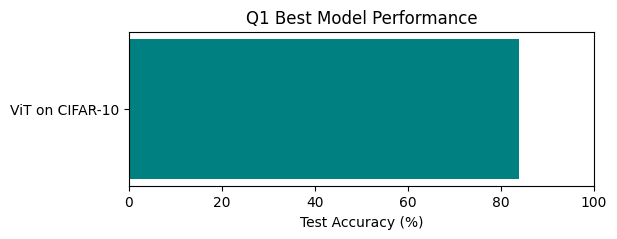

In [ ]:
# =====================================================
# FINAL RESULTS CELL (Must be run after the training cell)
# =====================================================

import matplotlib.pyplot as plt

# Load the best accuracy from the file saved by the training script
try:
    with open("final_acc.txt", "r") as f:
        best_acc_str = f.read().strip()
        best_acc_float = float(best_acc_str)
        best_acc_percent = best_acc_float * 100
except FileNotFoundError:
    print("Error: 'final_acc.txt' not found. Please run the training cell first.")
    best_acc_percent = 0.0

# Display the result clearly
print("=" * 40)
print(f"  FINAL BEST TEST ACCURACY: {best_acc_percent:.2f}%")
print("=" * 40)

# (Optional Visualization)
if best_acc_float > 0.0:
    plt.figure(figsize=(6, 2))
    plt.barh(['ViT on CIFAR-10'], [best_acc_percent], color='teal')
    plt.xlim(0, 100)
    plt.xlabel('Test Accuracy (%)')
    plt.title('Q1 Best Model Performance')
    plt.show()